In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from scipy import interpolate
from time import sleep
from tqdm import tqdm
from torch.autograd import Variable, grad
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
def ReadResponse(name):
  Response_set = []
  x = np.loadtxt(name,dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-300e-6))
  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)
  Response_set.append(list(Interpolated_Response))
  return np.array(Response_set).reshape(-1,1)

def Cumulative(wave):
    cu_list = []
    lists = wave.tolist()[0]
    length = len(lists)
    lists = [i**2 for i in lists]
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return np.array(cu_list[1:])

def FindValueIndex(seq, val):
    r = np.where(np.diff(np.sign(seq - val)) != 0)
    idx = r + (val - seq[r]) / (seq[r + np.ones_like(r)] - seq[r])
    idx = np.append(idx, np.where(seq == val))
    idx = np.sort(idx)
    return np.round(idx)

def FindTOF(wave):
  Ts = 2e-7
  Threshold = 0.25
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Time_response[index]) if val > 145e-6)

  return TOF*1e6

def FindTOF_longwindow(wave):
  Ts = 2e-7
  Threshold = 0.25
  Long_response = np.arange(145e-6, 225e-6+Ts/2, Ts)
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Long_response[index]) if val > 154e-6)
  return TOF*1e6

# GenerateSine(Peak-peak Amplitude,frequency,cycles)
def GenerateSine(A,freq,cycles):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  return Amp

def GenerateNoisySine(A,freq,cycles,sigma):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  noise_sigma = np.std(Amp)*sigma
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  Amp = Amp + np.random.normal(0,noise_sigma,len(Amp))
  return Amp

# consider the specific heat ratio
def Cal_percentage(t_A,M_B,delta_t,gas):
    if gas == 'Air':
      k_B = 1.4 # air
    elif gas == 'Argon':
      k_B = 1.66 # argon
    M_A =  4.002602 #  Gas A: helium [g/mol]
    k_A = 1.66
    M_ratio = (M_B-M_A)/M_A
    t_ratio = (t_A/(t_A+delta_t))**2
    nume = k_A * (1-t_ratio)
    denu = t_ratio*k_A*M_ratio-k_B+k_A
    percentage = nume/denu # percentage (minus means delay)
    return percentage*100

def Cal_deltaTOF(con_argon,con_air):

    R = 8.314 # individual gas constant (J/mol*K)
    T = 292 # absolute temperature (K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T/M_M)
    return (L / c_M * 1e3-t_A)

def Cal_deltaTOF_T(con_argon,con_air,T_initial,T_impurity):

    R = 8.314 # individual gas constant (J/mol*K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T_initial/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T_impurity/M_M)
    return (L / c_M * 1e3-t_A)

def CalVolume(array,time,gas):
    MFC_Helium = 0.1646 #(sl/s) / V
    MFC_Air = 118.56  #(sccm/s) / V

    interval = time / len(array)
    if gas == 'Helium':
        volume = np.trapz(array * MFC_Helium, dx=interval)
    elif gas == 'Air':
        volume = np.trapz(array * MFC_Air, dx=interval)
    return(volume)

def fmt_float_or_int(x):
    return f"{x:.3f}" if x != int(x) else f"{int(x)}"

def PlotConfuMatrix(label_test, y_pred):
    plt.figure(figsize=(6, 5), dpi=150)  # Figure size
    mpl.rcParams.update({'font.size': 14})  # Global font size

    class_names = ['Pure \n Helium', 'With \n Impurities']

    conf_mat = confusion_matrix(label_test, y_pred)

    # Calculate precision and recall for each class
    precisions = precision_score(label_test, y_pred, average=None)
    recalls = recall_score(label_test, y_pred, average=None)

    # Append precision values to the confusion matrix
    conf_mat_ext = np.vstack((conf_mat, precisions))

    # Append recall values and an empty cell to the confusion matrix
    recalls_ext = np.append(recalls, np.nan).reshape(-1, 1)
    conf_mat_ext = np.hstack((conf_mat_ext, recalls_ext))

    # Create custom tick labels including 'Precision' and 'Recall'
    class_names_ext = class_names + ['Recall']
    class_names_ext_y = class_names + ['Precision']

    sns.heatmap(conf_mat_ext, annot=True, cmap="Blues",
                xticklabels=class_names_ext, yticklabels=class_names_ext_y,
                fmt="", annot_kws={'fontsize': 14},
                cbar=False)

    # Display values as integers, except for precision and recall
    for text in plt.gca().texts:
        text.set_text(fmt_float_or_int(float(text.get_text())))

    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

    # Rotate y_tick labels
    plt.gca().yaxis.set_tick_params(rotation=90)
    plt.gca().xaxis.set_tick_params(rotation=0)

    plt.show()

In [4]:
# Define sine activation function
class Sine(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input):
    return torch.sin(input)

# Data Pre-processing

Read Excitations

In [ ]:
Excitation_set = []

In [ ]:
Ts = 2e-7
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_exci

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/500khz

for n in range(275):
  x = np.loadtxt('C1--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]))
  t_end = np.argmin(abs(x[:,0]-50e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Excitation = interpolator(Time_exci)

  Excitation_set.append(list(Interpolated_Excitation))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/500khz


In [ ]:
Excitation_set = np.array(Excitation_set)

In [ ]:
np.save('Excitation_set.npy',Excitation_set)

In [ ]:
test = GenerateSine(0.4,500,10)

0.9656379968908617


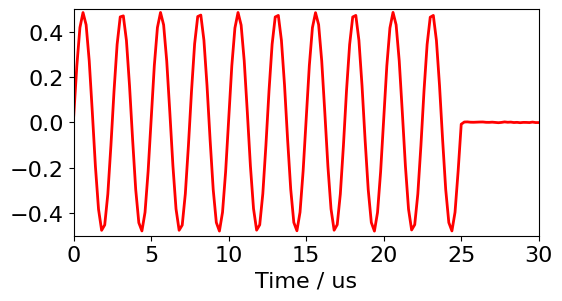

In [ ]:
from matplotlib import rcParams
plt.figure(figsize=(6,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 16})  # Global font size

idx = 145

plt.plot(Time_exci*1e6,Excitation_set[idx:idx+1,:].reshape(-1,1),linewidth=2,color='red')
#plt.plot(Time_exci*1e6,test.reshape(-1,1),linewidth=2,color='b')

plt.xlabel ('Time / us'),plt.xlim(0,30)
#plt.ylabel ('Amplitude / V')
plt.ylim(-.5,.5)
print(np.max(Excitation_set[idx:idx+1,:])-np.min(Excitation_set[idx:idx+1,:]))

Read Responses

In [ ]:
Response_set = []

In [ ]:
Time_response = np.arange(145e-6, 215e-6+Ts/2, Ts)

Time_response

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/600khz

for n in range(228):
  x = np.loadtxt('C2--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")

  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-215e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)

  Response_set.append(list(Interpolated_Response))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/600khz


In [ ]:
Response_set = np.array(Response_set)

In [ ]:
np.save('Response_set.npy',Response_set)

(137.2499999999998, 307.7500000000039, -0.6068803936243057, 0.5537904769182205)

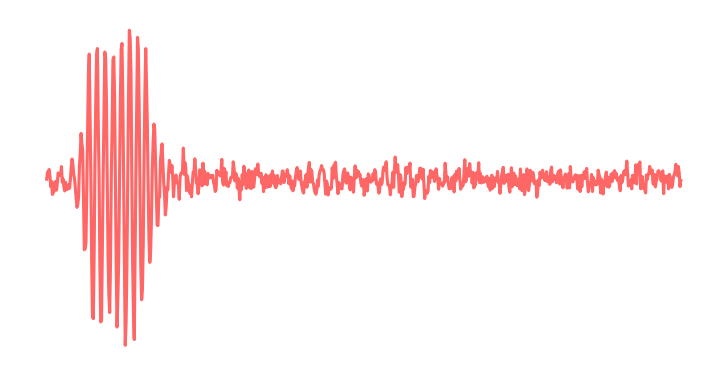

In [ ]:
plt.figure(figsize=(6,3),dpi=150)  # Figure size
mpl.rcParams.update({'font.size': 16})  # Global font size

#plt.plot(Time_response*1e6,Response_set[0:1,:].reshape(-1,1),linewidth=2,color='b')
#plt.plot(noise(1, device).cpu()[0,:],linewidth=2,color='r',alpha=0.6)
generated_signal = generate_signal(generator,device)
plt.plot(Time_response*1e6,generated_signal,color='r',alpha=0.6,linewidth = 1.5,label='Synthetic Response')
#plt.xlabel ('Time / us'),plt.xlim(145,215)
#plt.ylabel ('Amplitude / V')
#plt.ylim(-1,1)
plt.axis('off')

# Load Pre-processed Data (Please RUN FROM HERE)

In [4]:
%cd /content/gdrive/MyDrive/AME508/Low-Impurity

/content/gdrive/MyDrive/AME508/Low-Impurity


In [5]:
#Excitation_set = np.load('Input_set.npy') # 2351 is the # of samples, 251 is the length
#Response_set = np.load('Response_set.npy') # 351 is the length
#Concen_set = np.load('Concen_set.npy')

X_pure = np.load('X_pure_new.npy')
X_with_impurity = np.load('X_with_impurity_new.npy')

Ts = 2e-7 # sampling interval
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_response = np.arange(145e-6, 230e-6+Ts/2, Ts)

print(X_pure.shape)
print(X_with_impurity.shape)

(4718, 427)
(101700, 429)


In [6]:
# REMOVE <100mVpp
idx_to_delet = np.argwhere(np.ptp(X_pure[:,:-1], axis=1) < 0.2)
X_pure = np.delete(X_pure,idx_to_delet,axis=0)

idx_to_delet = np.argwhere(np.ptp(X_with_impurity[:,:-1], axis=1) < 0.2)
X_with_impurity = np.delete(X_with_impurity,idx_to_delet,axis=0)

In [8]:
#indices = np.random.choice(X_with_impurity.shape[0], size=X_pure.shape[0], replace=False)

# Select the rows from X_with_impurity using the random indices
#X_with_impurity_subset = X_with_impurity[indices, :]

In [7]:
# ONLY USE Argon and Air concentration less than 0.3% for CLASSIFICATION

mask = (X_with_impurity[:, -2] < 0.3) & (X_with_impurity[:, -1] < 0.3)

print(X_with_impurity.shape)
print(mask.shape)
print(X_with_impurity[mask].shape)
X_with_impurity_subset = X_with_impurity[mask,:-2]

(101700, 429)
(101700,)
(5450, 429)


In [8]:
X = np.vstack((X_pure,X_with_impurity_subset))

In [9]:
Response_train, Response_test, label_train, label_test = train_test_split(X[:,:-1], X[:,-1], test_size = 0.3,random_state=42)
train_input = Response_train
train_truth = label_train

X_train = np.column_stack((train_input,train_truth))

np.shape(X_train)

(6853, 427)

152.80000000000018
153.8000000000002
154.20000000000022
152.80000000000018
162.80000000000044
Concentrations of Ar and Air: [0.19622466]%,[0.19069597]%
160.6000000000004
Concentrations of Ar and Air: [0.19634906]%,[0.12742208]%
158.60000000000034
Concentrations of Ar and Air: [0.]%,[0.06561689]%
159.00000000000034
Concentrations of Ar and Air: [0.274892]%,[0.05929791]%


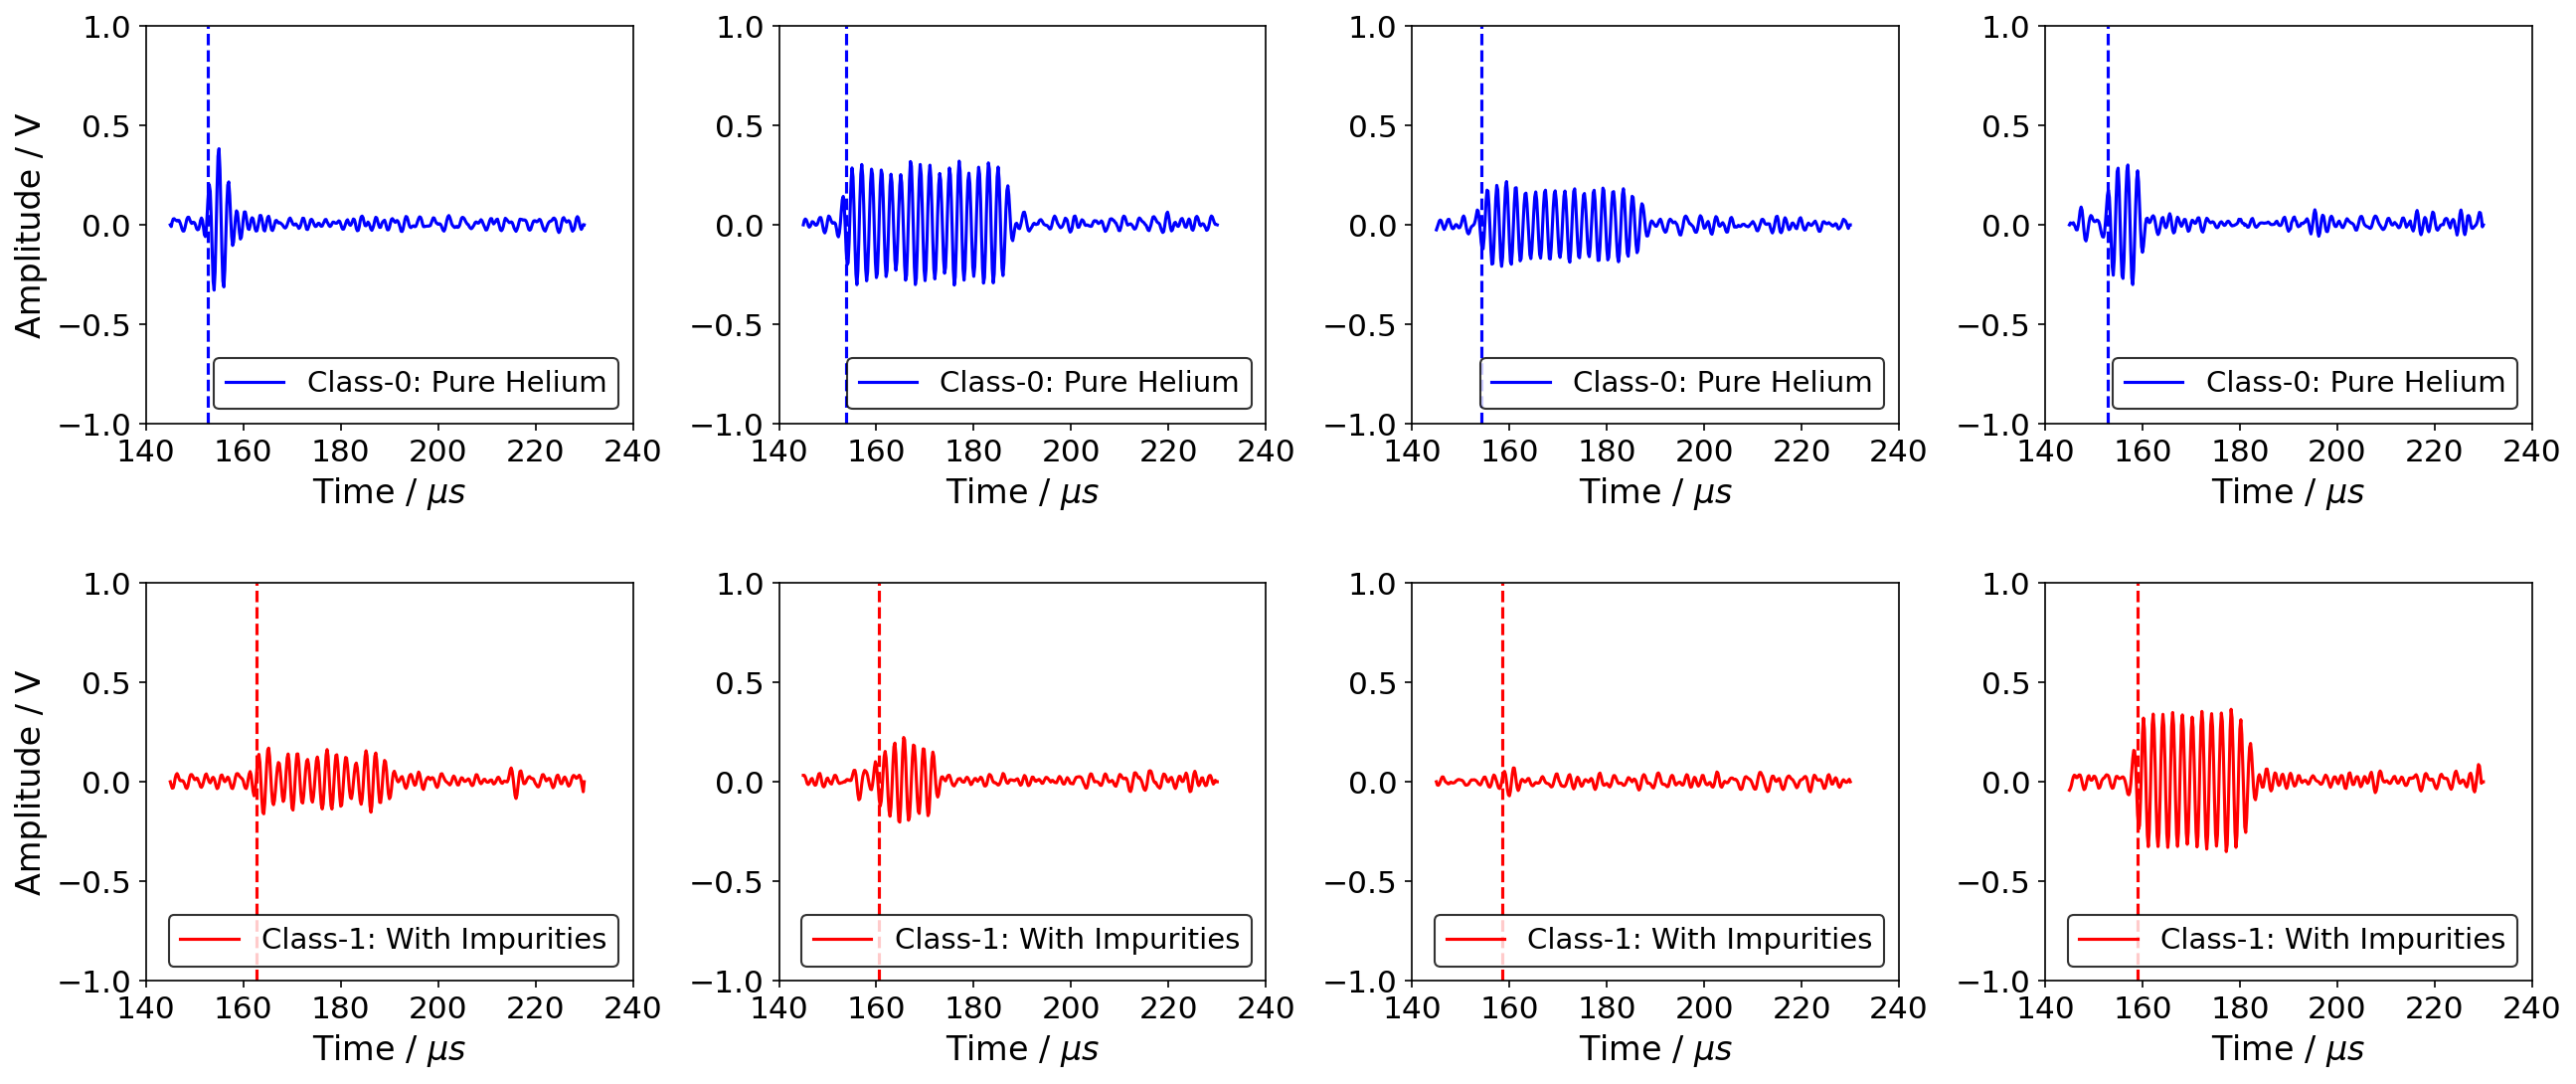

In [13]:
wave_helium = np.squeeze(X[np.argwhere(X[:,-1] == 0),:-1])
wave_impurity = np.squeeze(X[np.argwhere(X[:,-1] == 1),:-1])
Selected_concen = X_with_impurity[mask,-2:]

nr = 2
nc = 4

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr),dpi=150)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

for idx in range(nr*nc):
  if idx < 4:
    Wave_idx = np.random.randint(wave_helium.shape[0])
    ax[idx].plot(Time_response*1e6,wave_helium[Wave_idx:Wave_idx+1].reshape(-1,1),'-b',linewidth = 1.5,label='Class-0: Pure Helium')
    tof_pure = FindTOF(wave_helium[Wave_idx:Wave_idx+1])
    ax[idx].axvline(x=tof_pure, color='b', linestyle='--')

    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(140,240);ax[idx].set_ylim(-1,1)
    ax[idx].legend(loc='lower right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
    print(tof_pure)

  else:
    Wave_idx = np.random.randint(wave_impurity.shape[0])
    ax[idx].plot(Time_response*1e6,wave_impurity[Wave_idx:Wave_idx+1].reshape(-1,1),'-r',linewidth = 1.5,label='Class-1: With Impurities')

    tof_impure = FindTOF(wave_impurity[Wave_idx:Wave_idx+1])
    ax[idx].axvline(x=tof_impure, color='r', linestyle='--')

    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(140,240);ax[idx].set_ylim(-1,1)
    ax[idx].legend(loc='lower right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
    print(tof_impure)
    print(f'Concentrations of Ar and Air: {Selected_concen[Wave_idx:Wave_idx+1,0]}%,{Selected_concen[Wave_idx:Wave_idx+1,1]}%')
  if idx % 4 == 0:
    ax[idx].set_ylabel('Amplitude / V',fontsize=16)

# Decision Tree

In [37]:
CNN_model.eval()

inputs_train = torch.from_numpy(Response_train).to(torch.float32).to(device)
inputs_train = torch.reshape(inputs_train, (inputs_train.size(dim=0), 1, 426))

# Extract features from CNN
train_features = CNN_model(inputs_train, is_training=False)
train_features = train_features.detach().cpu().numpy()

# Similarly, for test features
inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 1, 426))

test_features = CNN_model(inputs_test, is_training=False)
test_features = test_features.detach().cpu().numpy()

Accuracy: 0.9908069458631257


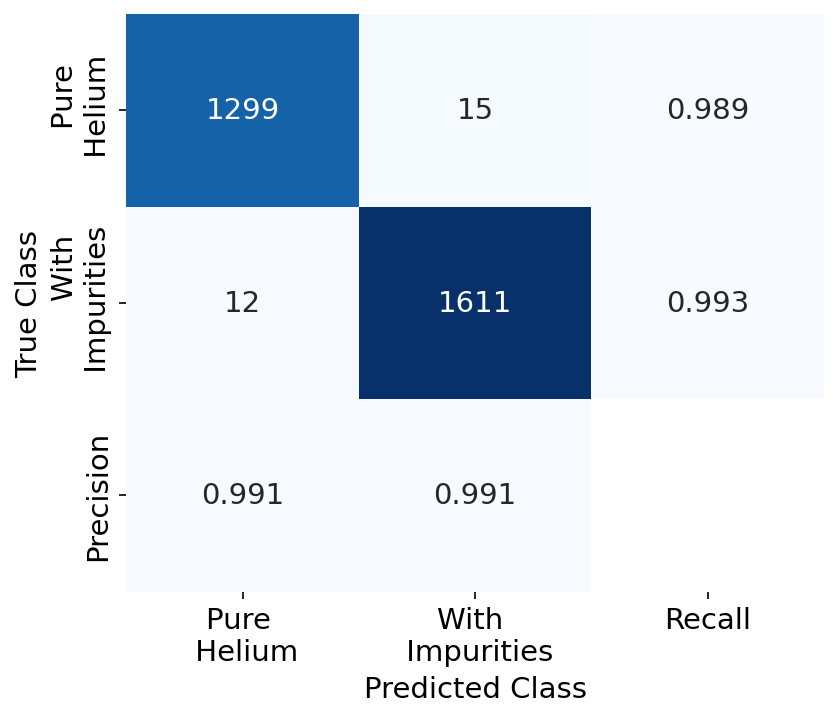

Test F1 Score: 0.992


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Instantiate the classifier with default hyperparameters
DT = DecisionTreeClassifier()

# Fit the classifier to the training data
DT.fit(train_features, label_train)

# Use the trained classifier to make predictions on the test data
y_pred = DT.predict(test_features)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(label_test, y_pred)
print(f"Accuracy: {accuracy}")
#tree.plot_tree(DT)
PlotConfuMatrix(label_test,y_pred)

test_f1 = f1_score(label_test, y_pred)

print(f"Test F1 Score: {test_f1:.3f}")

In [46]:
from joblib import dump

# Save the model to a file
dump(DT, 'DT_model.joblib')

['DT_model.joblib']

In [47]:
from joblib import load

# Load the model from the file
DT = load('DT_model.joblib')

# Random Forest

Test Accuracy: 98.4%
Test F1 Score: 98.6%


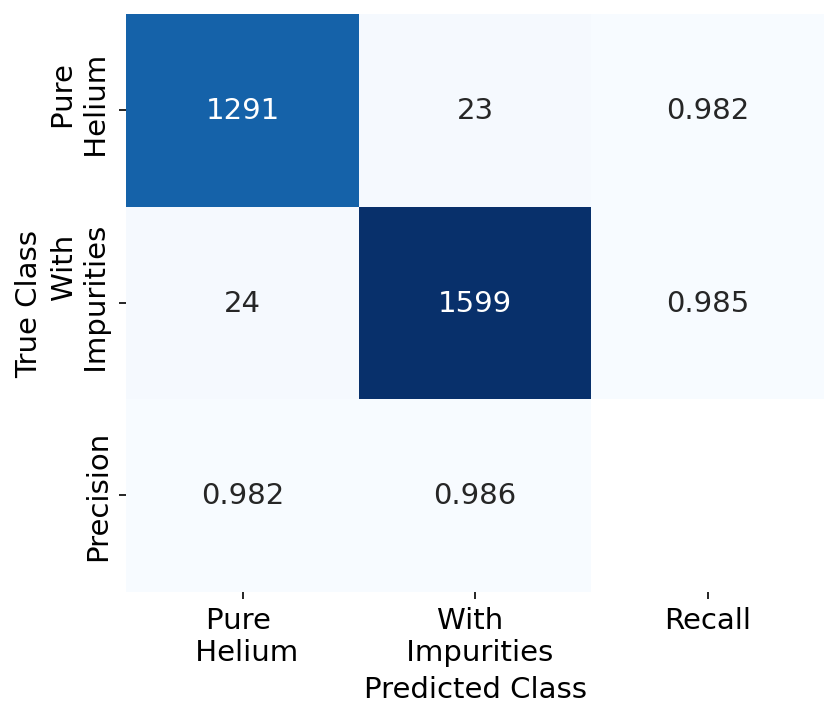

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

RF = RandomForestClassifier(n_estimators=5, max_depth=5)

# Train the model
RF.fit(train_features, label_train)

# Make predictions on the testing set
y_pred = RF.predict(test_features)

# Evaluate the model's accuracy
test_accuracy = accuracy_score(label_test, y_pred)
test_f1 = f1_score(label_test, y_pred)

print(f"Test Accuracy: {test_accuracy*100:.1f}%")
print(f"Test F1 Score: {test_f1*100:.1f}%")

PlotConfuMatrix(label_test,y_pred)

# Logistic Regression

Test Accuracy: 0.995
Test F1 Score: 0.995


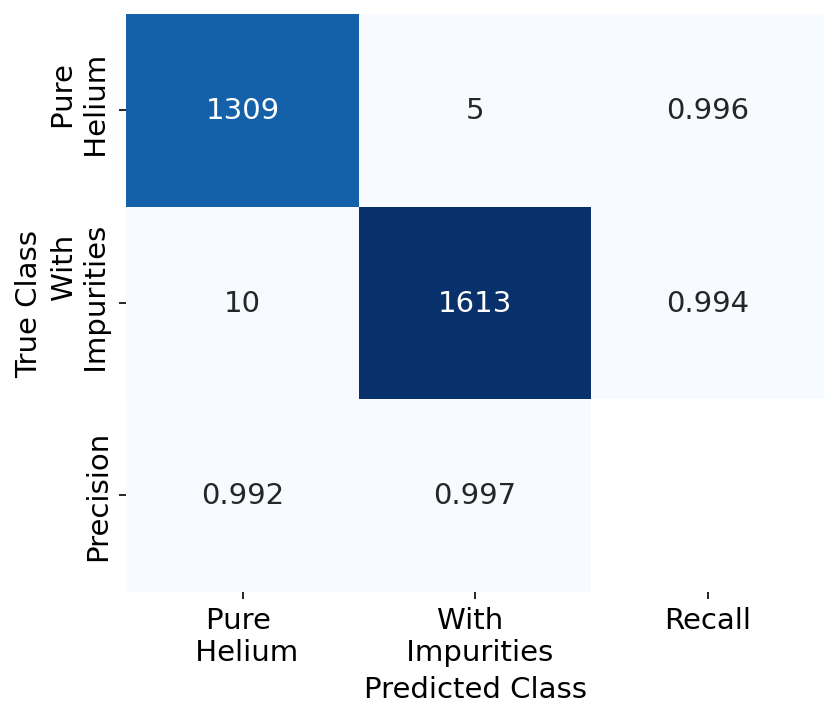

In [44]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression(max_iter=500)

# Train the model on the data
model.fit(train_features, label_train)

# Make predictions on the testing set
y_pred = model.predict(test_features)

# Evaluate the model's accuracy
test_accuracy = accuracy_score(label_test, y_pred)
test_f1 = f1_score(label_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")

PlotConfuMatrix(label_test,y_pred)

In [45]:
from joblib import dump

# Save the model to a file
dump(model, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [ ]:
from joblib import load

# Load the model from the file
loaded_model = load('logistic_regression_model.joblib')

# KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k_values = np.arange(1, 31)
accuracy_scores = []
for k in k_values:
  # Initialize a KNN classifier with k
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the classifier on the training data
  knn.fit(train_input, train_truth)

  # Predict the classes of the test data using the trained classifier
  y_pred = knn.predict(Response_test)

  # Calculate the accuracy of the classifier
  accuracy = accuracy_score(label_test, y_pred)
  accuracy_scores.append(accuracy)

In [ ]:
# Plot the accuracy scores vs. k
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Accuracy vs. K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_input)

# Visualize the results
fig, ax = plt.subplots()
colors = ['blue', 'green']
class_names = ['Pure Helium', 'With Impurities']

for i in range(2):
    ax.scatter(X_pca[train_truth == i, 0], X_pca[train_truth == i, 1], c=colors[i], label=class_names[i])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
plt.show()

In [ ]:
X_test = pca.fit_transform(Response_test)
# Visualize the results
fig, ax = plt.subplots()
colors = ['blue', 'green']
class_names = ['Pure Helium', 'With Impurities']

for i in range(2):
    ax.scatter(X_test[label_test == i, 0], X_test[label_test == i, 1], c=colors[i], label=class_names[i])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
plt.show()

Cluster labels: [0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0]
Cluster centers: [[-0.92679542  0.01978569]
 [ 2.15064065 -0.04591294]]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


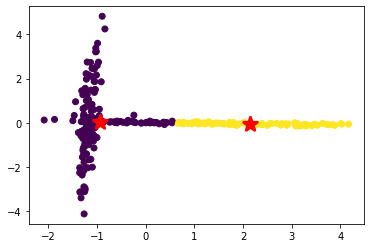

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(X_pca)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the cluster centers
centers = kmeans.cluster_centers_

# Print the results
print("Cluster labels:", labels)
print("Cluster centers:", centers)

# Plot the data points with color-coded clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=200, linewidths=3, color='r')

plt.show()

Testing set WCSS: 0.765846972934557


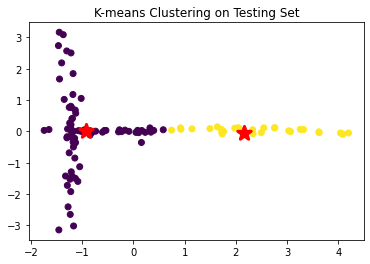

In [ ]:
from sklearn.metrics import mean_squared_error
test_labels = kmeans.predict(X_test)

# Calculate the WCSS for the testing set
test_wcss = mean_squared_error(X_test, kmeans.cluster_centers_[test_labels])

# Print the WCSS value
print("Testing set WCSS:", test_wcss)
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_labels, cmap='viridis')

# Plot the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', s=200, linewidths=3, color='r')

plt.title('K-means Clustering on Testing Set')
plt.show()

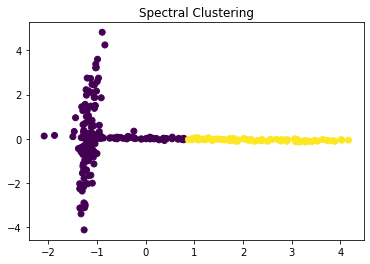

In [ ]:
from sklearn.cluster import SpectralClustering

# Create a spectral clustering object with the number of clusters and similarity metric
n_clusters = 2
similarity_metric = 'rbf'
spectral = SpectralClustering(n_clusters=n_clusters, affinity=similarity_metric)

# Fit the spectral clustering model to the data
spectral.fit(X_pca)

# Get the cluster assignments
cluster_labels = spectral.labels_

# Visualize the clusters

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Spectral Clustering')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_score(X_pca, cluster_labels)

0.50240524326101

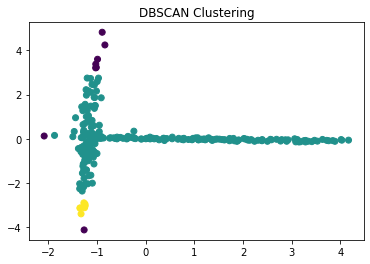

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=5)

# Fit the algorithm to the data
dbscan.fit(X_pca)

# Get the predicted cluster labels (-1 indicates an outlier)
predicted_labels = dbscan.labels_

# Visualize the clusters

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

# Create custom dataset class

In [31]:
class DataSet(torch.utils.data.Dataset):
  def __init__(self, ds):
    self.data = ds

  def __len__(self):
    return len(self.data[:,:])

  def __getitem__(self, idx):
    data = self.data[idx]
    return data

# Generators
batch_size = 64
trainingData = DataSet(X_train)
training_generator = torch.utils.data.DataLoader(trainingData,batch_size=batch_size,shuffle=True)

# Build and Train Neural Network

In [32]:
import torch.nn.functional as F

class CNNcoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 4, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=0)

        self.fc1 = nn.Linear(16 * 6, 16)
        self.fc2 = nn.Linear(16, 2)
        self.pool = nn.MaxPool1d(2, stride=2)
        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x, is_training=True):
        self.act = nn.ReLU()

        x = self.pool(self.act(self.conv1(x)))

        x = self.pool(self.act(self.conv2(x)))

        x = self.pool(self.act(self.conv3(x)))

        x = torch.flatten(x, 1)

        if is_training:
            x = self.act(self.fc1(x))
            x = self.fc2(x)

        return x

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# create the model
CNN_model = CNNcoder().to(device)

loss_fn = nn.CrossEntropyLoss()
max_epochs = 50

optimizer = optim.Adam(CNN_model.parameters(), lr=1e-3, betas=(0.9, 0.999),weight_decay=1e-4)

train_loss = []
test_loss = []
train_acc_history = []
test_acc_history = []

inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 1, 426))
groundtruth_test = torch.from_numpy(label_test).to(device).type(torch.LongTensor)

for epoch in tqdm(range(max_epochs)):
  for index, data in enumerate(training_generator):

    inputs_train = data[:,:-1].to(torch.float32).to(device)
    inputs_train = torch.reshape(inputs_train, (inputs_train.size(dim=0), 1, 426))
    groundtruth_train = data[:,-1].flatten().to(device).type(torch.LongTensor)

    # zero the parameter gradients
    optimizer.zero_grad()

    # make prediction and evaluate loss
    prediction = CNN_model(inputs_train)

    # evaluate loss
    tran_loss = loss_fn(prediction, groundtruth_train)

    # find the gradients using back-propagation
    tran_loss.backward()

    # update the weights
    optimizer.step()

  # training accuracy
  train_prediction = CNN_model(inputs_train)
  train_prediction_classes = torch.argmax(train_prediction, dim=1)
  train_accuracy = torch.mean((train_prediction_classes == groundtruth_train).float())
  train_acc_history.append(train_accuracy.item())

  # testing accuracy
  test_prediction = CNN_model(inputs_test)
  test_prediction_classes = torch.argmax(test_prediction, dim=1)
  test_accuracy = torch.mean((test_prediction_classes == groundtruth_test).float())
  test_acc_history.append(test_accuracy.item())

  # training loss
  train_loss.append(tran_loss.item())

  # testing loss
  test_loss_i = loss_fn(CNN_model(inputs_test), groundtruth_test).cpu().detach().numpy()
  test_loss_i = test_loss_i.tolist()
  test_loss.append(test_loss_i)

  sleep(0)

cpu


100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [49]:
print(train_acc_history[-1])
print(test_acc_history[-1])

1.0
0.9959142208099365


In [36]:
PATH = './Classification-Low-impurity.pth'
torch.save(CNN_model.state_dict(), PATH)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH = './Classification-Low-impurity.pth'

# create the model
CNN_model = CNNcoder().to(device)

CNN_model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

cpu


<All keys matched successfully>

# Visualization

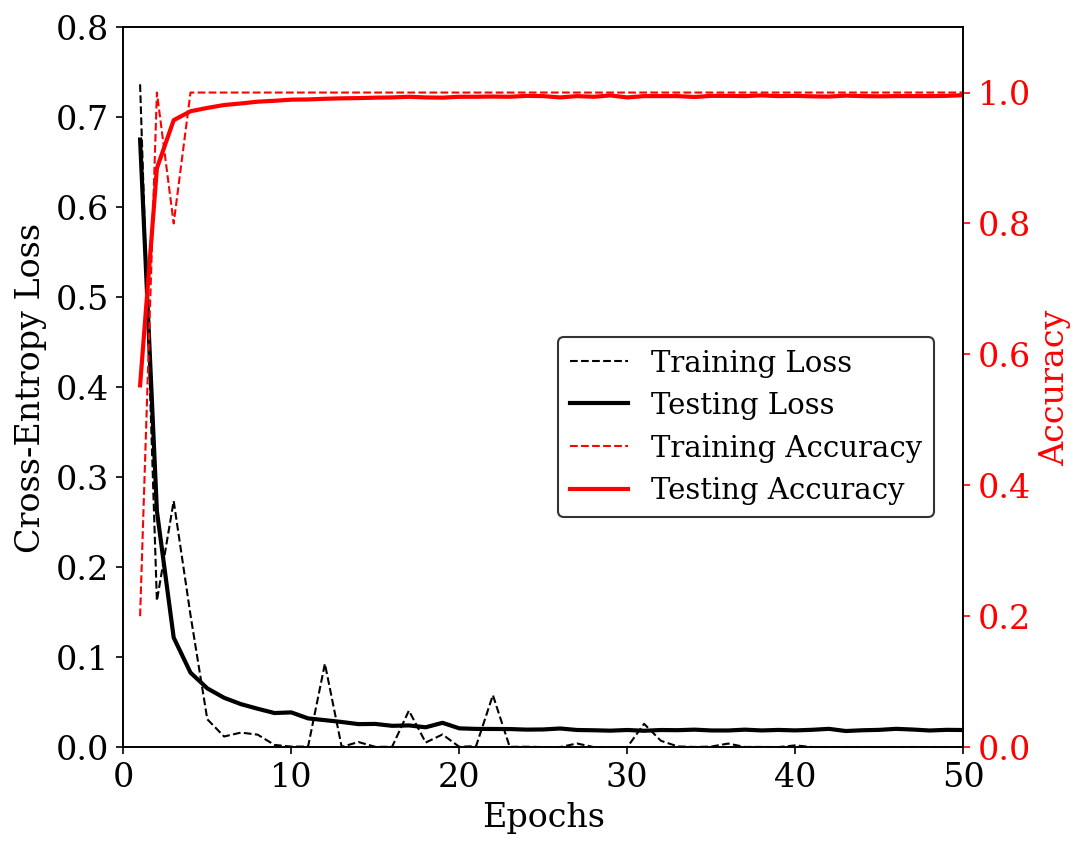

In [34]:
nc = 1
nr = 1
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr, nc, figsize=(7*nc, 6*nr), dpi=150)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

epoNum = np.arange(1, max_epochs+1)
line1, = plt.plot(epoNum, train_loss, '--k', linewidth=1, label='Training Loss')
line2, = plt.plot(epoNum, test_loss, '-k', linewidth=2, label='Testing Loss')

ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Cross-Entropy Loss', fontsize=16,color='k')
ax.tick_params(axis='y', which='major', labelsize=16, color='k')
ax.set_xlim([0, max_epochs])
ax.set_ylim([0, 0.8])
ax.yaxis.set_tick_params(colors='k', labelsize=16)

# Adding accuracy on the right y-axis
ax2 = ax.twinx()
line3, = ax2.plot(epoNum, np.array(train_acc_history), '--r', linewidth=1, label='Training Accuracy')
line4, = ax2.plot(epoNum, np.array(test_acc_history), '-r', linewidth=2, label='Testing Accuracy')
ax2.set_ylabel('Accuracy', fontsize=16, color='r')
ax2.tick_params(axis='y', which='major', labelsize=16, color='r')
ax2.yaxis.set_tick_params(colors='r', labelsize=16)
ax2.set_ylim([0, 1.1])

# Combining the legends
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='lower left', edgecolor='k', bbox_to_anchor=(0.5, 0.3),fontsize=14, frameon=True, ncol=1)

plt.rcdefaults()

In [ ]:
# plot the output vs ground truth

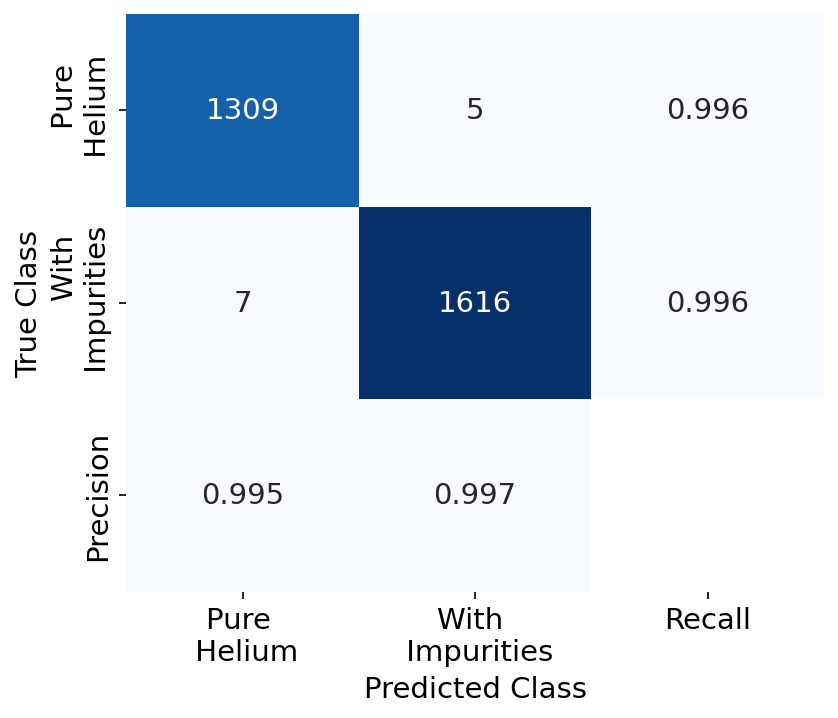

Test Accuracy: 0.996
Test F1 Score: 0.996


In [35]:
# Calculate the confusion matrix
inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 1, 426))
predictions_test = torch.argmax(CNN_model(inputs_test), axis=1)
PlotConfuMatrix(groundtruth_test,predictions_test)

test_accuracy = accuracy_score(groundtruth_test, predictions_test)
test_f1 = f1_score(groundtruth_test, predictions_test)

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")